In [5]:
import  chess
import chess.engine
import numpy as np
import tdchess.train
import tensorflow as tf
import pdb
import random

In [26]:
SKIP_FIRST_MOVES = 6
MAX_POSITIONS_PER_GAME = 5
MAX_GAMES = 2e6

def parse_result(result_header):
    if '1-0' in result_header:
        return 1
    if '0-1' in result_header:
        return -1
    if '1/2-1/2' in result_header:
        return 0

def augment_board(board):  
    ''' randomise two moves '''
    for _ in range(2):
        random_move = random.choice(list(board.legal_moves))
        board.push(random_move)
    return board
    
def parse_game(game):
    board = chess.Board()
    fens = []
    for uci in game.mainline_moves():
        pieces_before = len(board.piece_map().keys())
        board.push(uci)
        # Determine if something was taken
        pieces_after = len(board.piece_map().keys())
        if board.fullmove_number > SKIP_FIRST_MOVES and pieces_before == pieces_after:
            if random.randint(0,10) >= 7 and len(fens) < MAX_POSITIONS_PER_GAME:
                board_copy = augment_board(board.copy())
                fens.append(board_copy.fen())
    return fens

with open('data/ccrl/CCRL-4040.[1189229].pgn', 'r') as f:
    fens = []
    results = []
    i = 0 
    while True and i < MAX_GAMES:
        game = chess.pgn.read_game(f)
        
        if game is None:
            break
        
        result_header = game.headers["Result"]
        result = parse_result(result_header)
        
        # Skip drawn game(low signal)
        if result == 0:
            continue

        f_ = parse_game(game)
        for fen in f_:
            fens.append(fen)
            results.append(result)

        if i % 500 == 0:
            print("Loop ", i, "Positions = ", len(fens))
        i = i + 1

print(len(fens))

Loop  0 Positions =  5
Loop  500 Positions =  2505
Loop  1000 Positions =  5005
Loop  1500 Positions =  7505
Loop  2000 Positions =  10005
Loop  2500 Positions =  12505
Loop  3000 Positions =  15005
Loop  3500 Positions =  17504
Loop  4000 Positions =  20004
Loop  4500 Positions =  22504
Loop  5000 Positions =  25004
Loop  5500 Positions =  27504
Loop  6000 Positions =  30004
Loop  6500 Positions =  32504
Loop  7000 Positions =  35004
Loop  7500 Positions =  37504
Loop  8000 Positions =  40004
Loop  8500 Positions =  42504
Loop  9000 Positions =  45004
Loop  9500 Positions =  47504
Loop  10000 Positions =  50004
Loop  10500 Positions =  52504
Loop  11000 Positions =  55004
Loop  11500 Positions =  57504
Loop  12000 Positions =  60004
Loop  12500 Positions =  62504
Loop  13000 Positions =  65004
Loop  13500 Positions =  67504
Loop  14000 Positions =  70004
Loop  14500 Positions =  72504
Loop  15000 Positions =  75004
Loop  15500 Positions =  77504
Loop  16000 Positions =  80004
Loop  16

KeyboardInterrupt: 

In [ ]:
def show_board(fen):
    print(fen)
    board = chess.Board(fen)
    return board
show_board(fens[1000])

In [107]:
len(fens)

1465915

In [108]:
len(results)

1465915

In [29]:
#np.save('data/ccrl/fens_15e5_v2.npy',np.array(fens))
#np.save('data/ccrl/results_15e5_v2.npy',np.array(results))

In [42]:
path = "/usr/local/Cellar/stockfish/12/bin/stockfish"
engine = chess.engine.SimpleEngine.popen_uci(path)
chess.engine.Limit(depth=0)

def get_training_data(board):

    x = []
    # add meta
    tt = [1,0] if board.turn else [0,1]
    piece_map = board.piece_map()
    empty = [0 for _ in range(12)]
    pieces = ['p','n','b','r','q','k','P','N','B','R','Q','K']

    rep = [empty.copy() for _ in range(8*8)]

    castle_rights = [0,0,0,0]
    if board.has_kingside_castling_rights(chess.WHITE):
        castle_rights[0] = 1
    if board.has_queenside_castling_rights(chess.WHITE):
        castle_rights[1] = 1
    if board.has_kingside_castling_rights(chess.BLACK):
        castle_rights[2] = 1
    if board.has_queenside_castling_rights(chess.BLACK):
        castle_rights[3] = 1

    for key in piece_map:
        val = str(piece_map[key])
        ind = pieces.index(val)

        label = None
        if ind <= 5 and not board.turn: #black piece, black to move
            label = 1
        if ind <= 5 and board.turn: #black piece, white to move
            label = -1

        if ind > 5 and board.turn: #white piece, white to move
            label = 1
        if ind > 5 and not board.turn: #black piece, black to move
            label = -1

        rep[key][ind] = label
    rep = np.array(rep).flatten()
    x.extend(rep)
    x.extend(tt)
    x.extend(castle_rights)

    return x

X = []
Y = []
for fen, result in zip(fens, results):
    board = chess.Board(fen)
    ev = engine.analyse(board, chess.engine.Limit(depth=0))

    fen = board.fen()
    x = get_training_data(board)
    try:
        y = float(str(ev['score'].white()))
        
        X.append(x)
        Y.append(y)
        
        if len(X) % 1000 == 0:
            print("Step {}".format(len(X)))
    except:
        pass

Step 1000
Step 2000
Step 3000
Step 4000
Step 5000
Step 6000
Step 7000
Step 8000
Step 9000
Step 10000
Step 11000
Step 12000
Step 13000
Step 14000
Step 15000
Step 16000
Step 17000
Step 18000
Step 19000
Step 20000
Step 21000
Step 22000
Step 23000
Step 24000
Step 25000
Step 26000
Step 27000
Step 28000
Step 29000
Step 30000
Step 31000
Step 32000
Step 33000
Step 34000
Step 35000
Step 36000
Step 37000
Step 38000
Step 39000
Step 40000
Step 41000
Step 42000
Step 43000
Step 44000
Step 45000
Step 46000
Step 47000
Step 48000
Step 49000
Step 50000
Step 51000
Step 52000
Step 53000
Step 54000
Step 55000
Step 56000
Step 57000
Step 58000
Step 59000
Step 60000
Step 61000
Step 62000
Step 63000
Step 64000
Step 65000
Step 66000
Step 67000
Step 68000
Step 69000
Step 70000
Step 71000
Step 72000
Step 73000
Step 74000
Step 75000
Step 76000
Step 77000
Step 78000
Step 79000
Step 80000
Step 81000
Step 82000
Step 83000
Step 84000
Step 85000
Step 86000
Step 87000
Step 88000
Step 89000
Step 90000
Step 91000
Step 920

In [ ]:
import matplotlib.pyplot as plt

len(X)
np.mean(Y)
len(Y)
min(Y)

def normalise(Y):
    mi = min(Y)
    mx = max(Y)
    Y_norm = []
    for y in Y:
        y_ = (y - mi) / (mx - mi)
        Y_norm.append(y_)
    return Y_norm


plt.hist(Y[0:3000], bins='auto')
plt.show()

In [79]:
def denormalise(normalized_d, max_d, min_d):
    return normalized_d * (max_d - min_d) + min_d

print(max(Y_norm))
print(min(Y_norm))



1.0
0.0


NameError: name 'Y_' is not defined

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,Y)

np.save("data/ccrl/15e5_v2_xtrain.npy", np.array(X_train))
np.save("data/ccrl/15e5_v2_ytrain.npy", np.array(y_train))

np.save("data/ccrl/15e5_v2_xtest.npy", np.array(X_test))
np.save("data/ccrl/15e5_v2_ytest.npy", np.array(y_test))



In [76]:
y_train_ = normalise(y_train)
y_test_ = normalise(y_test)

np.save("data/ccrl/15e5_v2_ytrain_norm.npy", np.array(y_train_))
np.save("data/ccrl/15e5_v2_ytest_norm.npy", np.array(y_test_))

In [94]:
len(X)
print(y_train[1], y_train_[1])
print(denormalise(y_train_[1], max(y_train), min(y_train)))

v = 0.0810
print(denormalise(v, max(y_train), min(y_train)))

v1 = 129.9252
v2 = 0.0958

print(v1 / max(y_test))
print(v2 / max(y_test_))

print()
#MAE SGD
#1464/1464 [==============================] - 237s 162ms/step - loss: 0.1943 - mae: 0.1944 - val_loss: 0.1045 - val_mae: 0.1045
#Epoch 2/100
#1464/1464 [==============================] - 127s 87ms/step - loss: 0.0855 - mae: 0.0855 - val_loss: 0.1063 - val_mae: 0.1063
#Epoch 3/100
#1464/1464 [==============================] - 137s 94ms/step - loss: 0.0810 - mae: 0.0810 - val_loss: 0.0985 - val_mae: 0.0985
#Epoch 4/100
#1464/1464 [==============================] - 137s 94ms/step - loss: 0.0789 - mae: 0.0789 - val_loss: 0.0958 - val_mae: 0.0958
#Epoch 5/100
#1464/1464 [==============================] - 136s 93ms/step - loss: 0.0777 - mae: 0.0777 - val_loss: 0.0951 - val_mae: 0.0951
#1464/1464 [==============================] - 124s 85ms/step - loss: 0.0765 - mae: 0.0765 - val_loss: 0.0911 - val_mae: 0.0911

80.0 0.48054545454545455
80.0
-2117.5
0.06137231931979215
0.0958


In [101]:
model = tf.keras.models.load_model("/Users/silfverstrom/Workspace/link/projects/td-chess/output/15e5_v2_adam/15e5_v2_adam")

In [107]:
model.predict(np.array(X_test[50:60]))

array([[0.38691938],
       [0.40697092],
       [0.46836346],
       [0.46771616],
       [0.53443354],
       [0.47964364],
       [0.37852377],
       [0.52612716],
       [0.49178618],
       [0.38652927]], dtype=float32)

In [108]:
y_test_[50:60]

[0.4988339552238806,
 0.5310167910447762,
 0.5361473880597015,
 0.5135261194029851,
 0.5165578358208955,
 0.5902518656716418,
 0.43050373134328357,
 0.6098414179104478,
 0.5823227611940298,
 0.40718283582089554]

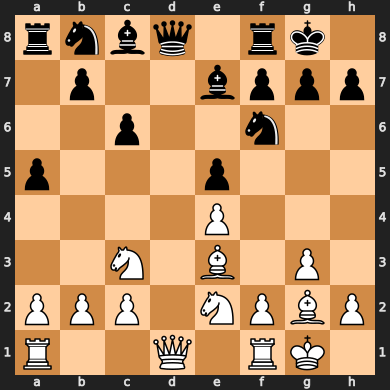

In [153]:
model.predict(np.array([get_training_data(board)]))

array([[-13.494867]], dtype=float32)

In [118]:
path = "/usr/local/Cellar/stockfish/12/bin/stockfish"
engine = chess.engine.SimpleEngine.popen_uci(path)
chess.engine.Limit(depth=0)

def find_best_move(board):
    if board.turn:
        best_score =(-99999, None)

    else:
        best_score =(99999, None)
    for move in board.legal_moves:
        board.push(move)
        score = model.predict(np.array([get_training_data(board)]))
        board.pop()
        
        if score < best_score[0] and not board.turn:
            best_score = (score, move)
        if score > best_score[0] and board.turn:
            best_score = (score, move)

    print(best_score)
    return best_score

def get_back(fen):
    i = 401
    #fen = 'N1b2k1r/pp1p1ppp/2p5/8/5N2/5P2/PPP3PP/R3KB1R b KQ - 0 15'
    #board = chess.Board(fens[i])
    board = chess.Board(fen)

    this_score = model.predict(np.array([get_training_data(board)]))
    score, move = find_best_move(board)
    ev = engine.analyse(board, chess.engine.Limit(depth=0))
    engine_score = float(str(ev['score'].white()))

    print(score, move, Y[i], this_score, engine_score)
    print("centipawns", denormalise(score, max(y_train), min(y_train)))
    return board

(array([[0.43551874]], dtype=float32), Move.from_uci('c7a8'))
[[0.43551874]] c7a8 574.0 [[0.5116699]] 209.0
centipawns [[-167.64697]]


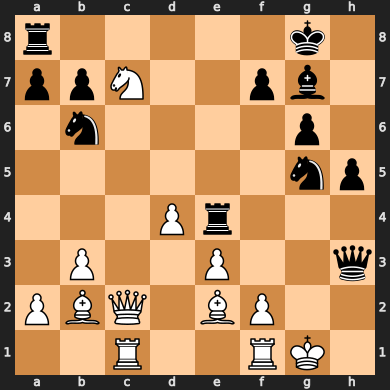

In [119]:
get_back('r5k1/ppN2pb1/1n4p1/6np/3Pr3/1P2P2q/PBQ1BP2/2R2RK1 w - - 0 22')

(array([[0.52009577]], dtype=float32), Move.from_uci('d7d5'))
[[0.52009577]] d7d5 574.0 [[0.51061654]] 1361.0
centipawns [[297.5266]]


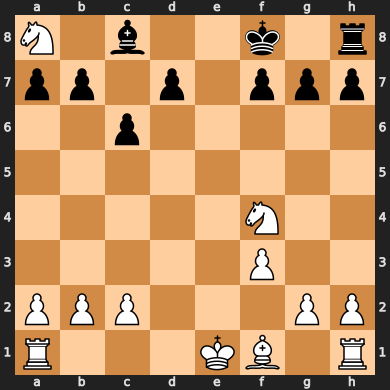

In [120]:
get_back('N1b2k1r/pp1p1ppp/2p5/8/5N2/5P2/PPP3PP/R3KB1R b KQ - 0 15')

(array([[0.40522367]], dtype=float32), Move.from_uci('b2a1'))
[[0.40522367]] b2a1 574.0 [[0.48495665]] 0.0
centipawns [[-334.26978]]


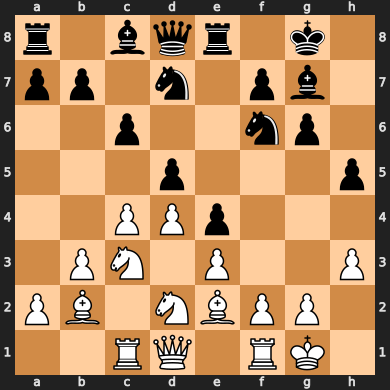

In [121]:
get_back('r1bqr1k1/pp1n1pb1/2p2np1/3p3p/2PPp3/1PN1P2P/PB1NBPP1/2RQ1RK1 w - - 0 13')